# DuckDB + Parquet Data Exploration Template

In [1]:
import duckdb
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
from pathlib import Path
from tqdm import tqdm
from shapely import wkb

# --- Configuration ---

In [2]:
BASE = Path("/Users/kyledorman/data/planet_coverage/points_30km/")  # <-- update this

# Example path patterns
f_pattern = "*/results/*/*/*/*/data.parquet"
all_files_pattern = str(BASE / f_pattern)

# Combined list used later when we search individual files
all_parquets = list(BASE.glob(f_pattern))

len(all_parquets)

766119

In [3]:
# Create the base map centered on the calculated location
ca_ocean = gpd.read_file(BASE / "ca_ocean.geojson")
query_df_orig = gpd.read_file(BASE / "ocean_grids.gpkg")
query_df = query_df_orig.to_crs(ca_ocean.crs)
query_ca = query_df[query_df.geometry.intersects(ca_ocean.union_all())]

GRID_ID = 32724
hex_id = f"{GRID_ID:06x}"  # unique 6‑digit hex, e.g. '0f1a2b'
d1, d2, d3 = hex_id[:2], hex_id[2:4], hex_id[4:6]
GRID_PATH = BASE / "dove" / "results" / "2023" / d1 / d2 / d3
FILE_PATH = GRID_PATH / "data.parquet"
SKYSAT_GRID_PATH = BASE / "skysat" / "results" / "2023" / d1 / d2 / d3
SKYSAT_FILE_PATH = SKYSAT_GRID_PATH / "data.parquet"

assert FILE_PATH.exists()
assert SKYSAT_FILE_PATH.exists()

query_grid = query_ca[query_ca.cell_id == GRID_ID]

len(query_ca), len(query_grid)

/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


(293, 1)

In [89]:
# Create the base map centered on the calculated location
centroid = ca_ocean.geometry[0].centroid
base_map = folium.Map(location=[centroid.y, centroid.x], zoom_start=5, width=1000, height=800)

for idx, geo in enumerate(ca_ocean.geometry):
    folium.GeoJson(
        geo,
        name=str(idx),
        style_function=lambda feature: {
            "color": "red",
            "weight": 4,
        }
    ).add_to(base_map)

# # Add each GeoJSON file to the map
# # Add polygons to the map
for _, row in query_ca.iterrows():
    cell_id = row["cell_id"]
    folium.GeoJson(
        row.geometry,
        popup=str(cell_id),
        tooltip=str(cell_id),
        style_function=lambda feature: {
            "color": "blue",
            "weight": 2,
        }
    ).add_to(base_map)

for _, row in query_grid.iterrows():
    cell_id = row["cell_id"]
    folium.GeoJson(
        row.geometry,
        style_function=lambda feature: {
            "color": "green",
            "weight": 2,
        }
    ).add_to(base_map)

# Display the map
base_map

In [90]:
def load_gdf(pth, crs):
    df_pd = pd.read_parquet(pth)
    df_pd["geometry"] = df_pd["geometry_wkb"].apply(wkb.loads)  # type: ignore
    df_pd = df_pd.drop(columns=["geometry_wkb"])
    satellite_gdf = gpd.GeoDataFrame(df_pd, geometry="geometry", crs="EPSG:4326").to_crs(crs)
    return satellite_gdf

ss_df = load_gdf(SKYSAT_FILE_PATH, query_df_orig.crs)
d_df = load_gdf(FILE_PATH, query_df_orig.crs)

In [91]:
ss_df

,id,acquired,item_type,satellite_id,instrument,cell_id,has_8_channel,has_sr_asset,clear_percent,quality_category,ground_control,publishing_stage,satellite_azimuth,sun_azimuth,sun_elevation,view_angle,geometry
0,20241029_174343_ssc5_u0001,2024-10-29 17:43:43.961000,SkySatCollect,SSC5,SkySat,32724,False,True,96.0,standard,True,finalized,282.700012,143.300003,30.700001,20.299999,"POLYGON ((-10808181.689 4128931.957, -10808727..."
1,20241017_224635_ssc6_u0001,2024-10-17 22:46:35.062500,SkySatCollect,SSC6,SkySat,32724,False,True,98.0,standard,True,finalized,282.899994,229.399994,27.900000,21.200001,"POLYGON ((-10802374.644 4172933.676, -10803452..."
2,20241008_173853_ssc5_u0001,2024-10-08 17:38:53.433000,SkySatCollect,SSC5,SkySat,32724,False,True,97.0,standard,True,finalized,279.299988,136.500000,36.099998,5.300000,"POLYGON ((-10808370.678 4129043.205, -10808986..."
3,20241004_222910_ssc6_u0001,2024-10-04 22:29:10.861000,SkySatCollect,SSC6,SkySat,32724,False,True,100.0,standard,True,finalized,151.899994,228.199997,34.700001,29.100000,"POLYGON ((-10769129.142 4177575.174, -10770150..."
4,20240929_223153_ssc9_u0001,2024-09-29 22:31:53.870000,SkySatCollect,SSC9,SkySat,32724,False,True,94.0,standard,True,finalized,283.299988,229.699997,36.200001,14.400000,"POLYGON ((-10788523.21 4177455.966, -10788511...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,20231204_225007_ssc14_u0001,2023-12-04 22:50:07.875000,SkySatCollect,SSC14,SkySat,32724,False,True,87.0,standard,True,finalized,239.100006,221.000000,17.600000,21.200001,"POLYGON ((-10745907.776 4218253.031, -10745900..."
280,20231201_222307_ssc8_u0001,2023-12-01 22:23:07.437000,SkySatCollect,SSC8,SkySat,32724,False,True,63.0,standard,True,finalized,274.899994,216.399994,21.500000,1.700000,"POLYGON ((-10813346.353 4133084.362, -10814309..."
281,20231201_222341_ssc8_u0001,2023-12-01 22:23:41.000000,SkySatCollect,SSC8,SkySat,32724,False,True,76.0,standard,True,finalized,195.199997,216.500000,21.500000,26.100000,"POLYGON ((-10817867.582 4132844.688, -10818913..."
282,20231201_222235_ssc8_u0001,2023-12-01 22:22:35.000000,SkySatCollect,SSC8,SkySat,32724,False,True,40.0,standard,True,finalized,9.200000,216.300003,21.600000,25.600000,"POLYGON ((-10817715.369 4132941.695, -10818831..."


In [92]:
d_df

,id,acquired,item_type,satellite_id,instrument,cell_id,has_8_channel,has_sr_asset,clear_percent,quality_category,ground_control,publishing_stage,satellite_azimuth,sun_azimuth,sun_elevation,view_angle,geometry
0,20241109_190542_29_2506,2024-11-09 19:05:42.290591,PSScene,2506,PSB.SD,32724,True,True,96.0,standard,True,finalized,277.700012,167.699997,34.700001,5.0,"POLYGON ((-10691932.142 4136647.863, -10721916..."
1,20241109_190539_96_2506,2024-11-09 19:05:39.963214,PSScene,2506,PSB.SD,32724,True,True,79.0,standard,True,finalized,277.700012,167.800003,34.500000,5.0,"POLYGON ((-10667559.999 4152874.505, -10697619..."
2,20241130_190302_44_24b7,2024-11-30 19:03:02.443024,PSScene,24b7,PSB.SD,32724,True,True,0.0,test,False,preview,276.100006,166.899994,29.799999,2.8,"POLYGON ((-10691587.481 4137125.736, -10720661..."
3,20241130_190300_39_24b7,2024-11-30 19:03:00.394523,PSScene,24b7,PSB.SD,32724,True,True,0.0,test,False,preview,276.100006,166.899994,29.700001,2.8,"POLYGON ((-10670590.591 4151170.67, -10699747...."
4,20241130_191150_90_24da,2024-11-30 19:11:50.904337,PSScene,24da,PSB.SD,32724,True,True,97.0,standard,True,finalized,278.000000,167.399994,29.400000,4.8,"POLYGON ((-10753076.882 4196080.554, -10783400..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15604,20231202_181300_93_24c1,2023-12-02 18:13:00.937652,PSScene,24c1,PSB.SD,32724,True,True,0.0,test,False,preview,277.899994,151.500000,24.299999,5.0,"POLYGON ((-10790715.429 4252297.313, -10821245..."
15605,20231202_181258_74_24c1,2023-12-02 18:12:58.745152,PSScene,24c1,PSB.SD,32724,True,True,0.0,test,False,preview,278.000000,151.600006,24.100000,5.0,"POLYGON ((-10766842.31 4267573.648, -10797445...."
15606,20231201_180850_46_24c0,2023-12-01 18:08:50.460904,PSScene,24c0,PSB.SD,32724,True,True,20.0,standard,True,finalized,272.100006,151.800003,24.400000,1.3,"POLYGON ((-10683611.302 4273956.745, -10714173..."
15607,20231201_180852_64_24c0,2023-12-01 18:08:52.649499,PSScene,24c0,PSB.SD,32724,True,True,26.0,standard,True,finalized,272.100006,151.699997,24.500000,1.3,"POLYGON ((-10707195.413 4258727.222, -10737685..."


In [108]:
filtered_d_df = d_df[
    (d_df.publishing_stage == "finalized") &
    (d_df.quality_category == "standard") &
    (d_df.has_sr_asset) &
    (d_df.ground_control)
]
filtered_ss_df = ss_df[
    (ss_df.clear_percent > 75) & 
    (ss_df.publishing_stage == "finalized") &
    (ss_df.quality_category == "standard") &
    (ss_df.has_sr_asset) &
    (ss_df.ground_control)
]

In [171]:
joined = gpd.overlay(
    filtered_d_df[["id", "geometry", "acquired", "has_8_channel"]], 
    filtered_ss_df[["id", "geometry", "acquired"]], 
    how="intersection"
)

/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [172]:
joined

,id_1,acquired_1,has_8_channel,id_2,acquired_2,geometry
0,20241109_190542_29_2506,2024-11-09 19:05:42.290591,True,20240815_164639_ssc2_u0001,2024-08-15 16:46:39.625,"POLYGON ((-10691932.142 4136647.863, -10690898..."
1,20241109_190542_29_2506,2024-11-09 19:05:42.290591,True,20240814_221711_ssc9_u0001,2024-08-14 22:17:11.000,"POLYGON ((-10696837.715 4133372.671, -10697311..."
2,20241109_190539_96_2506,2024-11-09 19:05:39.963214,True,20240815_164639_ssc2_u0001,2024-08-15 16:46:39.625,"POLYGON ((-10697619.841 4132854.267, -10690981..."
3,20241109_190539_96_2506,2024-11-09 19:05:39.963214,True,20240814_221711_ssc9_u0001,2024-08-14 22:17:11.000,"POLYGON ((-10697619.841 4132854.267, -10696815..."
4,20241130_191150_90_24da,2024-11-30 19:11:50.904337,True,20241004_222910_ssc6_u0001,2024-10-04 22:29:10.861,"POLYGON ((-10748975.465 4194818.938, -10749869..."
...,...,...,...,...,...,...
83946,20231201_180854_83_24c0,2023-12-01 18:08:54.838095,True,20240613_174224_ssc13_u0002,2024-06-13 17:42:24.866,"POLYGON ((-10726453.57 4227429.073, -10726757...."
83947,20231201_180854_83_24c0,2023-12-01 18:08:54.838095,True,20240613_174224_ssc13_u0001,2024-06-13 17:42:24.866,"POLYGON ((-10716478.345 4238986.806, -10716491..."
83948,20231201_180854_83_24c0,2023-12-01 18:08:54.838095,True,20240613_172152_ssc12_u0001,2024-06-13 17:21:52.503,"POLYGON ((-10713183.015 4237948.414, -10713321..."
83949,20231201_180854_83_24c0,2023-12-01 18:08:54.838095,True,20231204_225039_ssc14_u0001,2023-12-04 22:50:39.750,"POLYGON ((-10746850.086 4219288.516, -10746618..."


In [173]:
joined['acquired_delta'] = joined.acquired_1 - joined.acquired_2
joined['overlap_pct_crop'] = joined.geometry.area / 9 / 100 / 100

In [174]:
overlapping = joined[
    (joined.acquired_delta < pd.Timedelta(minutes=10)) & 
    (joined.acquired_delta > pd.Timedelta(minutes=-10)) &
    (joined.overlap_pct_crop > 1.0)
].copy()

overlapping

,id_1,acquired_1,has_8_channel,id_2,acquired_2,geometry,acquired_delta,overlap_pct_crop
41574,20240618_190920_03_2475,2024-06-18 19:09:20.033561,True,20240618_190128_ssc15_u0004,2024-06-18 19:01:28.447,"POLYGON ((-10726932.035 4235399.043, -10727006...",0 days 00:07:51.586561,98.739733
41575,20240618_190920_03_2475,2024-06-18 19:09:20.033561,True,20240618_190128_ssc15_u0003,2024-06-18 19:01:28.447,"POLYGON ((-10728797.172 4235955.453, -10730463...",0 days 00:07:51.586561,10.005813
41591,20240618_190918_19_2475,2024-06-18 19:09:18.195424,True,20240618_190128_ssc15_u0004,2024-06-18 19:01:28.447,"POLYGON ((-10727260.057 4234136.702, -10731279...",0 days 00:07:49.748424,352.900171
41592,20240618_190918_19_2475,2024-06-18 19:09:18.195424,True,20240618_190128_ssc15_u0003,2024-06-18 19:01:28.447,"POLYGON ((-10717552.238 4249915.692, -10717555...",0 days 00:07:49.748424,844.812030
41622,20240618_190916_35_2475,2024-06-18 19:09:16.357288,True,20240618_190128_ssc15_u0003,2024-06-18 19:01:28.447,"POLYGON ((-10721975.402 4247063.533, -10717545...",0 days 00:07:47.910288,84.302841
42629,20240615_181334_13_24b9,2024-06-15 18:13:34.135529,True,20240615_180457_ssc1_u0001,2024-06-15 18:04:57.625,"POLYGON ((-10816810.584 4143050.563, -10816418...",0 days 00:08:36.510529,642.392000


In [176]:
overlapping[["id_1", "id_2"]]

,id_1,id_2
41574,20240618_190920_03_2475,20240618_190128_ssc15_u0004
41575,20240618_190920_03_2475,20240618_190128_ssc15_u0003
41591,20240618_190918_19_2475,20240618_190128_ssc15_u0004
41592,20240618_190918_19_2475,20240618_190128_ssc15_u0003
41622,20240618_190916_35_2475,20240618_190128_ssc15_u0003
42629,20240615_181334_13_24b9,20240615_180457_ssc1_u0001


In [181]:
for dove_path in BASE.glob("dove/results/*/*/*/*/data.parquet"):
    skysat_path = Path(str(dove_path).replace("/dove/", "/skysat/"))
    if skysat_path.stat().st_size == 0:
        print(skysat_path)
        break

<Axes: >

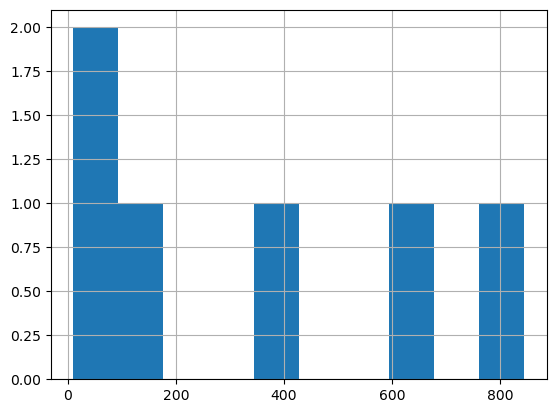

In [120]:
overlapping.overlap_pct_crop.hist()

In [179]:
# Create the base map centered on the calculated location
centroid = overlapping.to_crs(ca_ocean.crs).geometry.iloc[0].centroid
base_map = folium.Map(location=[centroid.y, centroid.x], zoom_start=8, width=1000, height=800)

for _, row in overlapping.to_crs(ca_ocean.crs).iterrows():
    geo = row.geometry
    if row.id_1 != "20240618_190920_03_2475":
        continue
    
    folium.GeoJson(
        geo,
        style_function=lambda feature: {
            "color": "red",
            "weight": 2,
        }
    ).add_to(base_map)

# Display the map
base_map

In [ ]:
grids_df = gpd.read_file(BASE / "coastal_grids.gpkg")

In [166]:
# initial spatial join: match coastal grids to query cells by containment
joined = gpd.overlay(
    overlapping[["id_1", "id_2", "geometry"]],
    grids_df[["cell_id", "geometry"]],
)

overlapping = overlapping.copy()

# Faster for large DataFrames
overlapping["_key"] = list(zip(overlapping["id_1"], overlapping["id_2"]))
joined["_key"] = list(zip(joined["id_1"], joined["id_2"]))

mask = overlapping["_key"].isin(joined["_key"])
joined.drop(columns="_key", inplace=True)

# separate those with overlap from those without
misses = ~mask
joined_missing = overlapping[misses]

KeyError: "['has_8_channel'] not in index"

In [159]:
joined_filtered = joined.copy()
joined_filtered["area"] = joined_filtered.geometry.area
joined_filtered = joined_filtered.sort_values(by="area", ascending=False).drop_duplicates(subset=["id_1", "id_2"])

# for any missing, assign nearest cell
if not joined_missing.empty:
    print(f"{len(joined_missing)} SkyDat-Dove grids lack overlap; assigning nearest cell")
    nearest = gpd.sjoin_nearest(
        left_df=joined_missing[["id_1", "id_2", "geometry"]],
        right_df=grids_df[["cell_id", "geometry"]],
        how="left",
    )
    # combine overlap and nearest
    joined_final = pd.concat([joined_filtered, nearest], ignore_index=True)
else:
    joined_final = joined_filtered

joined_final

3 SkyDat-Dove grids lack overlap; assigning nearest cell


,id_1,id_2,cell_id,geometry,area,index_right
0,20240615_181334_13_24b9,20240615_180457_ssc1_u0001,13218039,"POLYGON ((-10808672.199 4149359.312, -10808695...",1.983612e+07,NaN
1,20240618_190920_03_2475,20240618_190128_ssc15_u0004,13303391,"POLYGON ((-10731279.849 4232089.789, -10731198...",1.260477e+04,NaN
2,20240618_190918_19_2475,20240618_190128_ssc15_u0004,13303391,"POLYGON ((-10731279.849 4232089.789, -10731198...",1.260477e+04,NaN
3,20240618_190920_03_2475,20240618_190128_ssc15_u0003,13303391,"POLYGON ((-10728797.172 4235955.453, -10730463...",NaN,579672.0
4,20240618_190918_19_2475,20240618_190128_ssc15_u0003,13303391,"POLYGON ((-10717552.238 4249915.692, -10717555...",NaN,579672.0
5,20240618_190916_35_2475,20240618_190128_ssc15_u0003,13309053,"POLYGON ((-10721975.402 4247063.533, -10717545...",NaN,580100.0


In [160]:
overlapping

,id_1,acquired_1,id_2,acquired_2,geometry,acquired_delta,overlap_pct_crop
41574,20240618_190920_03_2475,2024-06-18 19:09:20.033561,20240618_190128_ssc15_u0004,2024-06-18 19:01:28.447,"POLYGON ((-10726932.035 4235399.043, -10727006...",0 days 00:07:51.586561,98.739733
41575,20240618_190920_03_2475,2024-06-18 19:09:20.033561,20240618_190128_ssc15_u0003,2024-06-18 19:01:28.447,"POLYGON ((-10728797.172 4235955.453, -10730463...",0 days 00:07:51.586561,10.005813
41591,20240618_190918_19_2475,2024-06-18 19:09:18.195424,20240618_190128_ssc15_u0004,2024-06-18 19:01:28.447,"POLYGON ((-10727260.057 4234136.702, -10731279...",0 days 00:07:49.748424,352.900171
41592,20240618_190918_19_2475,2024-06-18 19:09:18.195424,20240618_190128_ssc15_u0003,2024-06-18 19:01:28.447,"POLYGON ((-10717552.238 4249915.692, -10717555...",0 days 00:07:49.748424,844.812030
41622,20240618_190916_35_2475,2024-06-18 19:09:16.357288,20240618_190128_ssc15_u0003,2024-06-18 19:01:28.447,"POLYGON ((-10721975.402 4247063.533, -10717545...",0 days 00:07:47.910288,84.302841
42629,20240615_181334_13_24b9,2024-06-15 18:13:34.135529,20240615_180457_ssc1_u0001,2024-06-15 18:04:57.625,"POLYGON ((-10816810.584 4143050.563, -10816418...",0 days 00:08:36.510529,642.392000


In [165]:
joined_final.groupby("cell_id").id_1.count()

cell_id
13218039    1
13303391    4
13309053    1
Name: id_1, dtype: int64

In [170]:
len(ss_df), len(ss_df.id.unique())

(284, 284)

In [8]:
base = Path("/Users/kyledorman/data/planet_coverage/ca_only/")
all_dove_paths = list(base.glob("*/results/*/*/*/*/data.parquet"))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1380/1380 [00:00<00:00, 5693.02it/s]


(array([1152.,   43.,   38.,   39.,   45.,    8.,    7.,   12.,   17.,
          19.]),
 array([    0. ,  3166.7,  6333.4,  9500.1, 12666.8, 15833.5, 19000.2,
        22166.9, 25333.6, 28500.3, 31667. ]),
 <BarContainer object of 10 artists>)

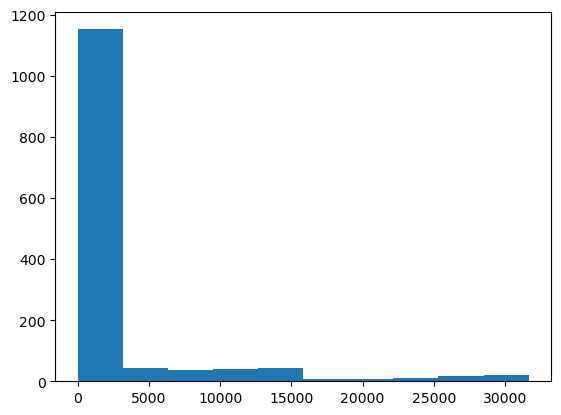

In [12]:
import os
import tqdm
import pyarrow.parquet as pq

def _parquet_empty(pth: Path) -> bool:
    """
    Return True if a Parquet file has zero rows without loading full data.
    """
    meta = pq.ParquetFile(pth).metadata
    return meta.num_rows == 0

counts = []
for dove_path in tqdm.tqdm(all_dove_paths):
    marker_path = dove_path.parent / ".ran"
    marker_path.touch()
    counts.append(pq.ParquetFile(dove_path).metadata.num_rows)
    if _parquet_empty(dove_path):
        os.remove(dove_path)


plt.figure()
plt.hist(counts)

In [14]:
max(counts)

31667

In [13]:
all_updated_paths = list(base.glob("*/results/*/*/*/*/data.parquet"))

len(all_dove_paths), len(all_updated_paths)

(1380, 397)